
# YOLOR: You Only Learn One Representation

YOLOR is the latest State-Of-the-Art Object Detection Model that is better and faster than YOLOv4, Scaled YOLOv4, YOLOv5 and PP-YOLOv2!

<p><br>

<div>
<img src="./Sourses/1.png" width="400" height="200"/>
</div>

<p><br>

# Connent to google drive


In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step-1: Read and Refine Data to yolo format




## UnZip Data

In [1]:
!unzip '/content/drive/MyDrive/Fruits/test_zip.zip' 
!unzip '/content/drive/MyDrive/Fruits/train_zip.zip' 

##Conver to yolo format

In [6]:

import glob
from numpy import expand_dims
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import glob
import os
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join
import cv2
import matplotlib.pyplot as plt
import glob
from shutil import copy

def getImagesInDir(dir_path):
    image_list = []
    for filename in glob.glob(dir_path + '/*.jpg'):
        image_list.append(filename)

    return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path_label,output_path_image, image_path):
    img = {'object':[]}
    img['filename'] = image_path
    basename = os.path.basename(image_path)
    copy(image_path,output_path_image) 
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path_label + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    img['width'] = w
    h = int(size.find('height').text)
    img['height'] = h
    objs = {}
    flag=False
    for obj in root.iter('object'):    
        difficult = obj.find('difficult').text
        cls = obj.find('name').text

        if cls not in classes or int(difficult)==1:
            continue
        objs['name'] = cls
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        xmin,xmax,ymin,ymax = float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text)
        b = (xmin,xmax,ymin,ymax)
        objs['xmin'],objs['xmax'],objs['ymin'],objs['ymax'] = xmin,xmax,ymin,ymax
        if w==0 or h==0:
            flag=False
        else:
            bb = convert((w,h), b)
            img['object'] += [objs]
            out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) +str(cls_id)+ '\n')
            flag=True

    return img,flag



classes = ['apple','banana','orange']  

dirs = ['train','test']
train_image_folder = "/content/train"
test_image_folder = "/content/test"


   
def process_annotation(name):
    all_imgs  =  []
    full_dir_path='/content/'+name+'/'
    output_path_label= '/content/Fruits/labels/'+name+'/'
    output_path_image= '/content/Fruits/images/'+name

    if not os.path.exists(output_path_label):
        os.makedirs(output_path_label)
    if not os.path.exists(output_path_image):
        os.makedirs(output_path_image)

    image_paths = getImagesInDir(full_dir_path)
    list_file = open('/content/Fruits/' + name+'.txt', 'w')

    for image_path in image_paths:
        
        img,flag=convert_annotation(full_dir_path, output_path_label,output_path_image, image_path)
        if flag == False:
            continue
        else:
              # for objs in img['object']:
              #   list_file.write(image_path+ ", "+ ", ".join([str(a) for a in [objs['xmin'],objs['ymin'],objs['xmax'],objs['ymax'],objs['name']]])+'\n')
              list_file.write(image_path+'\n')
              all_imgs += [img]
    list_file.close()

    print("Finished processing: " + full_dir_path)
    return all_imgs

all_imgs_train = process_annotation('train')
all_imgs_test = process_annotation('test')  

Finished processing: /content/train/
Finished processing: /content/test/


In [64]:
# f = open("/content/Fruits/train.txt", "r")
# print(f.read())

In [7]:
all_imgs_train[0]

{'filename': '/content/train/apple_71.jpg',
 'height': 368,
 'object': [{'name': 'apple',
   'xmax': 338.0,
   'xmin': 79.0,
   'ymax': 270.0,
   'ymin': 18.0},
  {'name': 'apple', 'xmax': 338.0, 'xmin': 79.0, 'ymax': 270.0, 'ymin': 18.0}],
 'width': 654}

In [8]:
len(all_imgs_train)

207

## Remove extra files

In [27]:
# to remove a whole of a directory
os.system("rm -rf /content/train/")
os.system("rm -rf /content/test/")

0

In [9]:
!ls

drive  Fruits  sample_data  test  train


# Step-2: Run YOLOR

In [12]:
import torch
from IPython.display import Image  # for displaying images

print('torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

torch 1.9.0+cu102 CPU


## Clone the repository
This is PyTorch implementation of YOLOv4 which is based on ultralytics/yolov5 (availabel in u5 bramch).

In [8]:
!git clone https://github.com/WongKinYiu/yolor

Cloning into 'yolor'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 371 (delta 102), reused 51 (delta 46), pack-reused 210
Receiving objects: 100% (371/371), 2.97 MiB | 9.55 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [9]:
cd /content/yolor

/content/yolor


In [10]:
!ls

cfg	 detect.py  LICENSE    requirements.txt  train.py
darknet  figure     models     scripts		 tune.py
data	 inference  README.md  test.py		 utils


## Install requirments

In [11]:
!pip install -qr requirements.txt

     |████████████████████████████████| 15.7 MB 71 kB/s 
     |████████████████████████████████| 776.7 MB 3.1 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.0 which is incompatible.
tensorflow-probability 0.13.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
tensorflow-gpu 2.2.0 requires gast==0.3.3, but you have gast 0.2.2 which is incompatible.
tensorflow-gpu 2.2.0 requires tensorboard<2.3.0,>=2.2.0, but you have tensorboard 2.1.1 which is incompatible.
tensorflow-gpu 2.2.0 requires tensorflow-estimator<2.3.0,>=2.2.0, but you have tensorflow-estimator 2.1.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible

## Install Mish CUDA


In [29]:
!git clone https://github.com/JunnYu/mish-cuda
%cd mish-cuda
!git reset --hard 6f38976064cbcc4782f4212d7c0c5f6dd5e315a8
!python setup.py build install
%cd ..

Cloning into 'mish-cuda'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 195 (delta 7), reused 79 (delta 3), pack-reused 107
Receiving objects: 100% (195/195), 208.77 KiB | 828.00 KiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/yolor/mish-cuda
HEAD is now at 6f38976 Update README.md
/usr/lib/python3.7/distutils/extension.py:131: UserWarning: Unknown Extension options: 'headers'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/mish_cuda
copying src/mish_cuda/__init__.py -> build/lib.linux-x86_64-3.7/mish_cuda
running egg_info
creating src/mish_cuda.egg-info
writing src/mish_cuda.egg-info/PKG-INFO
writing dependency_links to src/mish_cuda.egg-info/dependency_links.txt
writing requirements to src/mish_cuda.egg-info/requires.txt
writing top-level names to src/mish_cuda.egg-info/top_level

## Install PyTorch Wavelets


In [30]:
!git clone https://github.com/fbcotter/pytorch_wavelets
%cd pytorch_wavelets
!pip install .
%cd ..

Cloning into 'pytorch_wavelets'...
remote: Enumerating objects: 972, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 972 (delta 75), reused 89 (delta 45), pack-reused 836
Receiving objects: 100% (972/972), 6.80 MiB | 13.41 MiB/s, done.
Resolving deltas: 100% (659/659), done.
/content/yolor/pytorch_wavelets
Processing /content/yolor/pytorch_wavelets
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=54869 sha256=b5dd04f315d1ee3eaca393e967de1e0ee2c80fc7202ac477a4bd24cca6974fe4
  Stored in di

## Download pre-trained weights

In [32]:
!bash scripts/get_pretrain.sh


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1632      0 --:--:-- --:--:-- --:--:--  1625
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  142M    0  142M    0     0  61.9M      0 --:--:--  0:00:02 --:--:--  137M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1736      0 --:--:-- --:--:-- --:--:--  1743
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  305M    0  305M    0     0   110M      0 --:--:--  0:00:02 --:--:--  195M


## Training-FineTuning


In [1]:
!python train.py --epochs 10 --batch-size 16 --img 640 640 --data /content/drive/MyDrive/Fruits/Fruits-Data.yaml --cfg cfg/yolor_p6.cfg --weights /content/yolor/yolor_p6.pt --device 0 --name yolor_p6 --hyp hyp.scratch.1280.yaml 


python3: can't open file 'train.py': [Errno 2] No such file or directory


## Test using the new weights 

In [67]:
# !python test.py --data /content/drive/MyDrive/Fruits/Fruits-yolov3.yaml --img 640 --batch 32 --conf 0.001 --iou 0.65 --cfg cfg/yolor_p6.cfg --weights /content/yolor/runs/train/yolor_p68/weights/best.pt


##Show results of test batches

In [13]:
from IPython.display import Image
Image(filename='/content/yolor/runs/test/yolor_p6_val/test_batch0_pred.jpg') 


## Detect results on one test image e.g. mixed_21.jpg

In [54]:
!python detect.py --source /content/Fruits/images/test/mixed_21.jpg --cfg cfg/yolor_p6.cfg --weights /content/yolor/yolor_p6.pt --conf 0.1 --img-size 640


Namespace(agnostic_nms=False, augment=False, cfg='cfg/yolor_p6.cfg', classes=None, conf_thres=0.1, device='', img_size=640, iou_thres=0.5, names='data/coco.names', output='inference/output', save_txt=False, source='/content/Fruits/images/test/mixed_21.jpg', update=False, view_img=False, weights=['/content/yolor/yolor_p6.pt'])
image 1/1 /content/Fruits/images/test/mixed_21.jpg: 448x640 1 bananas, 1 apples, 5 oranges, Done. (0.096s)
Results saved to inference/output
Done. (0.247s)


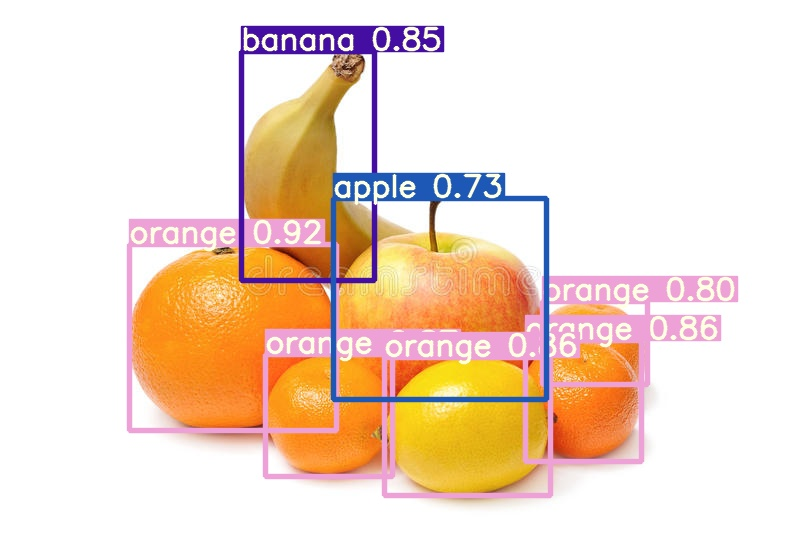

In [55]:
from IPython.display import Image
Image(filename='/content/yolor/inference/output/mixed_21.jpg') 

## Detect objects on webcam

In [62]:
# !python detect.py --source 0 --cfg cfg/yolor_p6.cfg --weights /content/yolor/runs/train/yolor_p68/weights/best.pt --conf 0.25 --img-size 640 --device 0

## Plot results

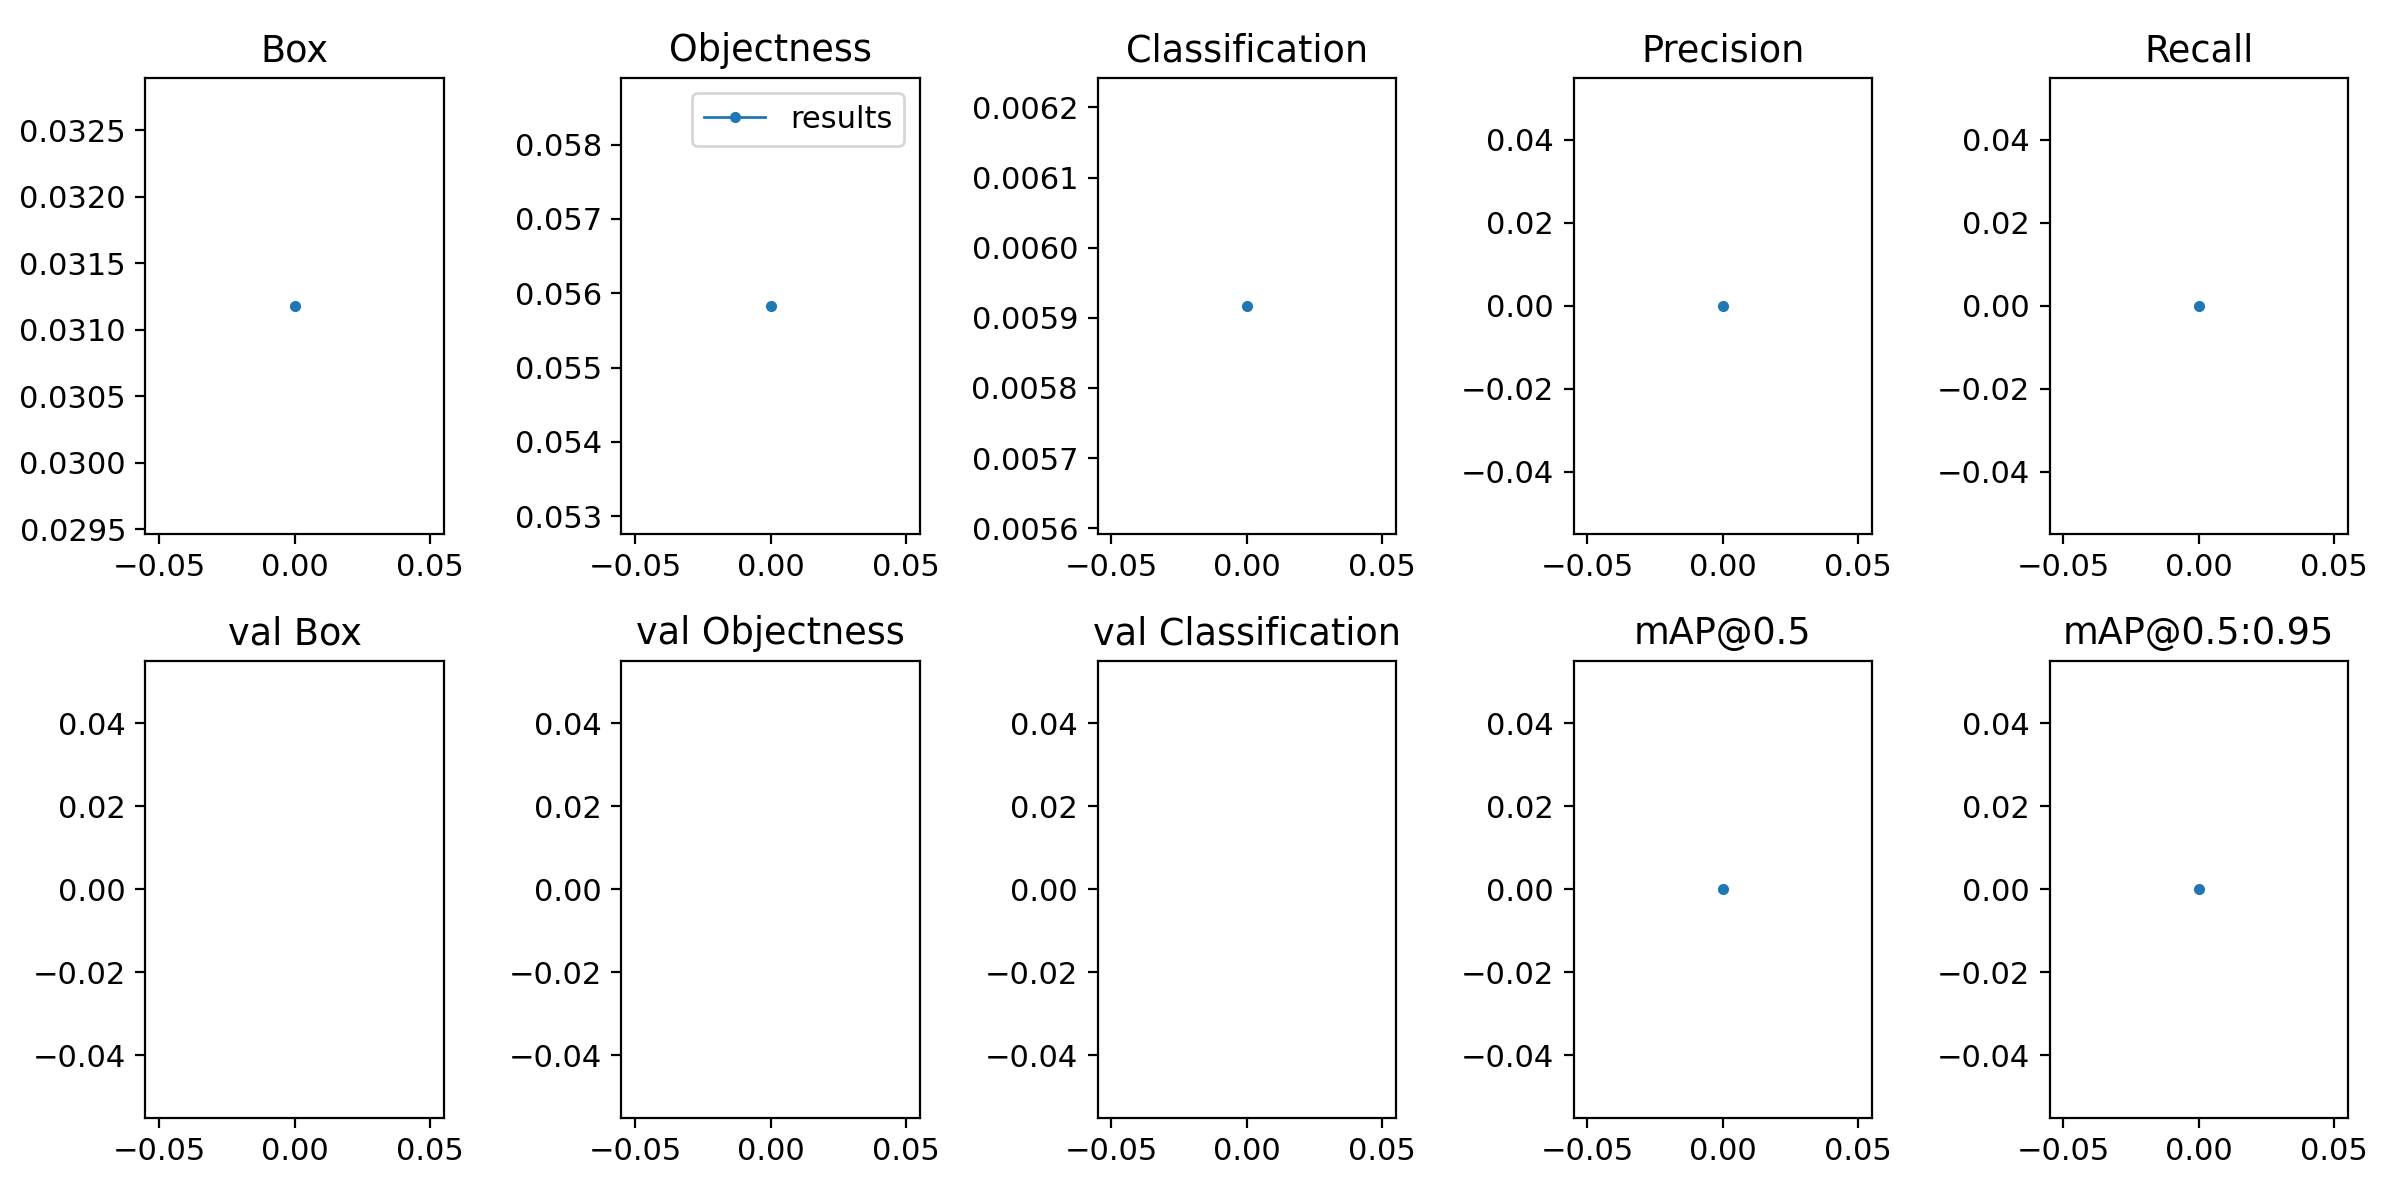

In [63]:
from utils.plots import plot_results 
Image(filename='/content/yolor/runs/train/yolor_p68/results.png', width=800)